In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os

In [2]:
# For Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Define the path to the saved data file
input_file_path_csv = '../data/processed/churn_data_engineered.csv'

In [4]:
# Load dataset
try:
    df_eng = pd.read_csv(input_file_path_csv)
    print("Engineered DataFrame loaded successfully!")
    print("Shape:", df_eng.shape)
    display(df_eng.head())
    df_eng.info() # Good idea to quickly check dtypes loaded correctly

except FileNotFoundError:
    print(f"Error: Data file not found at specified path.")
    print("Please ensure the previous notebook saved the file correctly.")
    # Stop execution or handle error
    exit()
except Exception as e:
    print(f"Error loading DataFrame: {e}")
    exit()

Engineered DataFrame loaded successfully!
Shape: (7043, 23)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureGroup,NumOptionalServices,HasInternet_NoAddons
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12 Months,1,False
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,One year,No,Mailed check,56.95,1889.50,No,25-36 Months,2,False
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12 Months,2,False
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37-48 Months,3,False
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12 Months,0,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gender                7043 non-null   object 
 1   SeniorCitizen         7043 non-null   int64  
 2   Partner               7043 non-null   object 
 3   Dependents            7043 non-null   object 
 4   tenure                7043 non-null   int64  
 5   PhoneService          7043 non-null   object 
 6   MultipleLines         7043 non-null   object 
 7   InternetService       7043 non-null   object 
 8   OnlineSecurity        7043 non-null   object 
 9   OnlineBackup          7043 non-null   object 
 10  DeviceProtection      7043 non-null   object 
 11  TechSupport           7043 non-null   object 
 12  StreamingTV           7043 non-null   object 
 13  StreamingMovies       7043 non-null   object 
 14  Contract              7043 non-null   object 
 15  PaperlessBilling     

# Feature Preprocessing for Modeling

In [5]:
# 1. Prepare Target Variable (y)
# Convert 'Churn' Yes/No to 1/0
label_encoder = LabelEncoder()
# Fit and transform in one step
df_eng['Churn_encoded'] = label_encoder.fit_transform(df_eng['Churn'])

# Verify mapping (usually 'No' -> 0, 'Yes' -> 1)
print("Label Encoding mapping for Churn:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Define target variable y
y = df_eng['Churn_encoded']

Label Encoding mapping for Churn:
{'No': np.int64(0), 'Yes': np.int64(1)}


In [6]:
# 2. Define Features (X)
# Drop original Churn column and the newly encoded target column
X = df_eng.drop(['Churn', 'Churn_encoded'], axis=1)

print("\nShape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("\nColumns in X:", X.columns.tolist())


Shape of features (X): (7043, 22)
Shape of target (y): (7043,)

Columns in X: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'TenureGroup', 'NumOptionalServices', 'HasInternet_NoAddons']


In [7]:
# 3. Split Data into Training and Testing Sets
# Use random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% for testing
    random_state=42, # For reproducible results
    stratify=y      # Important for imbalanced target variable!
)

print("\n--- Data Split ---")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True)) # Should be similar to y_train


--- Data Split ---
X_train shape: (5634, 22)
X_test shape: (1409, 22)
y_train distribution:
 Churn_encoded
0    0.734647
1    0.265353
Name: proportion, dtype: float64
y_test distribution:
 Churn_encoded
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [8]:
# 4. Identify Column Types in X_train
# Numerical columns (excluding binary treated as categorical)
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'NumOptionalServices']

# Categorical columns (include binary/ordinal if treating as categorical for OHE)
categorical_features = [col for col in X_train.columns if col not in numerical_features]
# Or be explicit:
# categorical_features = [
#     'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
#     'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
#     'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
#     'PaperlessBilling', 'PaymentMethod', 'TenureGroup', 'HasInternet_NoAddons',
#     'SeniorCitizen' # Treat SeniorCitizen (0/1) as categorical for OHE
# ]


# Ensure all columns are accounted for
print("\n--- Feature Types for Preprocessing ---")
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)
assert len(numerical_features) + len(categorical_features) == X_train.shape[1], "Mismatch in feature classification!"


--- Feature Types for Preprocessing ---
Numerical Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'NumOptionalServices']
Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup', 'HasInternet_NoAddons']


In [9]:
# 5. Create Preprocessing Pipelines

# Pipeline for numerical features: Scale data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', # Handle categories appearing only in test set
                             sparse_output=False)) # Get dense array output
])

In [10]:
# 6. Combine pipelines using ColumnTransformer
# This applies the specified transformers to the specified column lists
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any columns not specified (should be none here)
)

print("\nPreprocessor object created successfully.")


Preprocessor object created successfully.


In [11]:
# 7. Apply the preprocessor to the data

# Fit the preprocessor on the training data and transform it
print("Fitting and transforming X_train...")
X_train_processed = preprocessor.fit_transform(X_train)
print("X_train processing complete.")

# Transform the test data using the *already fitted* preprocessor
print("\nTransforming X_test...")
X_test_processed = preprocessor.transform(X_test)
print("X_test processing complete.")


# --- Verification ---
print("\n--- Processed Data Shapes ---")
print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

# Optional: Get feature names after OneHotEncoding (useful for interpretation later)
try:
    feature_names_out = preprocessor.get_feature_names_out()
    print("\nNumber of features after processing:", len(feature_names_out))
    # print("Feature names:", feature_names_out) # Can be very long
except Exception as e:
    print("\nCould not get feature names automatically:", e)
    # Manual construction might be needed depending on scikit-learn version

# Check a sample of the processed data (e.g., first 5 rows of X_train_processed)
print("\nSample of processed training data (first 5 rows, first 10 columns):")
print(pd.DataFrame(X_train_processed[:5, :10], columns=feature_names_out[:10] if 'feature_names_out' in locals() else None))

Fitting and transforming X_train...
X_train processing complete.

Transforming X_test...
X_test processing complete.

--- Processed Data Shapes ---
X_train_processed shape: (5634, 55)
X_test_processed shape: (1409, 55)

Number of features after processing: 55

Sample of processed training data (first 5 rows, first 10 columns):
   num__tenure  num__MonthlyCharges  num__TotalCharges  \
0     0.102371            -0.521976          -0.262257   
1    -0.711743             0.337478          -0.503635   
2    -0.793155            -0.809013          -0.749883   
3    -0.263980             0.284384          -0.172722   
4    -1.281624            -0.676279          -0.989374   

   num__NumOptionalServices  cat__gender_Female  cat__gender_Male  \
0                  0.507935                 0.0               1.0   
1                 -0.570530                 0.0               1.0   
2                  0.507935                 0.0               1.0   
3                  1.047168                 1.

# Baseline

In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    average_precision_score, # AUC-PR
    RocCurveDisplay,
    PrecisionRecallDisplay
)

In [13]:
print("--- Training Baseline Model (Logistic Regression) ---")

# Instantiate the model
# Increase max_iter if you get a convergence warning
baseline_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the processed training data
baseline_model.fit(X_train_processed, y_train)

print("Baseline model trained successfully.")

--- Training Baseline Model (Logistic Regression) ---
Baseline model trained successfully.


In [14]:
# Make Predictions on the Test Set
print("\n--- Making Predictions on Test Set ---")
y_pred_baseline = baseline_model.predict(X_test_processed)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_processed)[:, 1] # Probability of class 1 (Churn)

print("Predictions made.")


--- Making Predictions on Test Set ---
Predictions made.


In [15]:
#  Evaluate the Baseline Model
print("\n--- Baseline Model Evaluation ---")

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Not Churn (0)', 'Churn (1)']))

# AUC-ROC Score
auc_roc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)
print(f"AUC-ROC Score: {auc_roc_baseline:.4f}")

# Average Precision Score (AUC-PR) - More informative for imbalanced data
auc_pr_baseline = average_precision_score(y_test, y_pred_proba_baseline)
print(f"AUC-PR (Average Precision) Score: {auc_pr_baseline:.4f}")


--- Baseline Model Evaluation ---

Classification Report:
               precision    recall  f1-score   support

Not Churn (0)       0.84      0.90      0.87      1035
    Churn (1)       0.66      0.53      0.59       374

     accuracy                           0.80      1409
    macro avg       0.75      0.72      0.73      1409
 weighted avg       0.80      0.80      0.80      1409

AUC-ROC Score: 0.8433
AUC-PR (Average Precision) Score: 0.6438



Plotting Confusion Matrix...


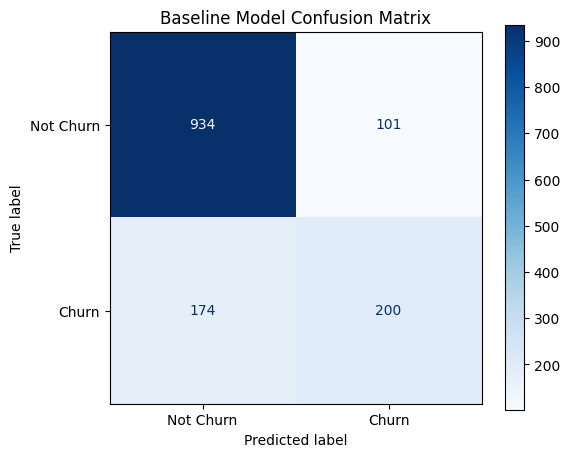

In [16]:
# Confusion Matrix
print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_baseline, labels=baseline_model.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churn', 'Churn'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_cm.plot(ax=ax, cmap='Blues')
plt.title('Baseline Model Confusion Matrix')
plt.show()


Plotting ROC Curve...


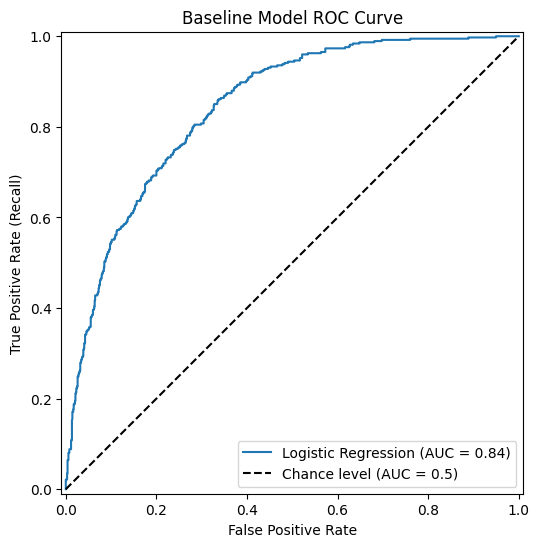

In [17]:
# ROC Curve
print("\nPlotting ROC Curve...")
fig, ax = plt.subplots(figsize=(7, 6))
RocCurveDisplay.from_estimator(baseline_model, X_test_processed, y_test, ax=ax, name='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)') # Add chance line
plt.title('Baseline Model ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()


Plotting Precision-Recall Curve...


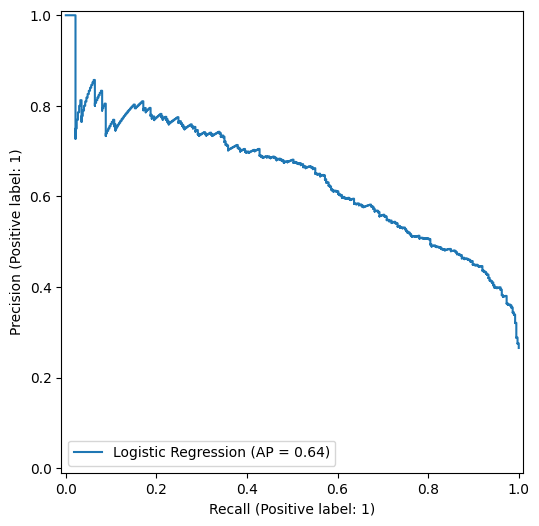

In [18]:
# Precision-Recall Curve
print("\nPlotting Precision-Recall Curve...")
fig, ax = plt.subplots(figsize=(7, 6))
PrecisionRecallDisplay.from_estimator(baseline_model, X_test_processed, y_test, ax=ax, name='Logistic Regression')

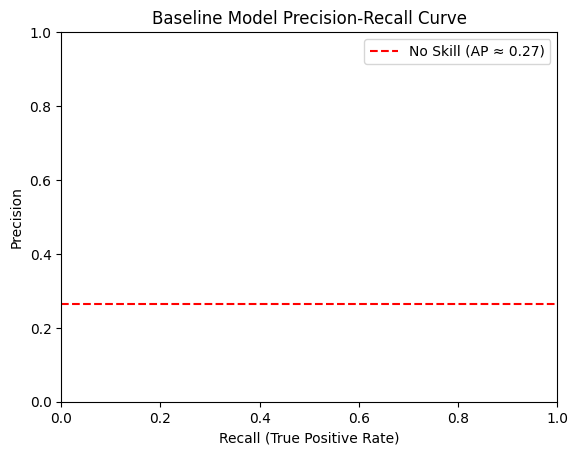

In [19]:
# Calculate baseline precision (overall churn rate in test set)
baseline_precision = y_test.mean()
plt.axhline(baseline_precision, color='r', linestyle='--', label=f'No Skill (AP ≈ {baseline_precision:.2f})')
plt.title('Baseline Model Precision-Recall Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Advanced Models

In [20]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [21]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [22]:
# 1.Train and evaluate Random Forest
print("--- Training Random Forest Model ---")

--- Training Random Forest Model ---


In [23]:
# Instantiate the model
# n_estimators=100 is a reasonable default, can be tuned later
# class_weight='balanced' helps with imbalance
rf_model = RandomForestClassifier(n_estimators=100,
                                   random_state=42,
                                   class_weight='balanced',
                                   n_jobs=-1) # Use all available CPU cores

In [24]:
# Train the model
rf_model.fit(X_train_processed, y_train)
print("Random Forest model trained successfully.")

Random Forest model trained successfully.


In [25]:
# Make Predictions
print("\nMaking Predictions with Random Forest...")
y_pred_rf = rf_model.predict(X_test_processed)
y_pred_proba_rf = rf_model.predict_proba(X_test_processed)[:, 1]
print("Predictions made.")


Making Predictions with Random Forest...
Predictions made.


In [26]:
# Evaluate the Model
print("\n--- Random Forest Model Evaluation ---")


--- Random Forest Model Evaluation ---


In [27]:
# Classification Report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['Not Churn (0)', 'Churn (1)']))


Classification Report (Random Forest):
               precision    recall  f1-score   support

Not Churn (0)       0.82      0.89      0.86      1035
    Churn (1)       0.61      0.47      0.53       374

     accuracy                           0.78      1409
    macro avg       0.72      0.68      0.69      1409
 weighted avg       0.77      0.78      0.77      1409



In [28]:
# AUC-ROC Score
auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC Score (Random Forest): {auc_roc_rf:.4f}")

AUC-ROC Score (Random Forest): 0.8176


In [29]:
# Average Precision Score (AUC-PR)
auc_pr_rf = average_precision_score(y_test, y_pred_proba_rf)
print(f"AUC-PR (Average Precision) Score (Random Forest): {auc_pr_rf:.4f}")

AUC-PR (Average Precision) Score (Random Forest): 0.6004



Plotting Confusion Matrix (Random Forest)...


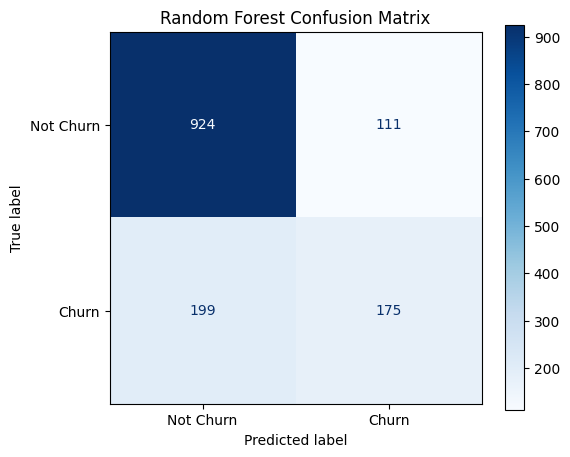

In [30]:
# Confusion Matrix
print("\nPlotting Confusion Matrix (Random Forest)...")
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_model.classes_)
disp_cm_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Not Churn', 'Churn'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_cm_rf.plot(ax=ax, cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [31]:
# Optional: ROC and Precision-Recall Curves (can get cluttered, maybe plot final model later)
# RocCurveDisplay.from_estimator(rf_model, X_test_processed, y_test, name='Random Forest')
# PrecisionRecallDisplay.from_estimator(rf_model, X_test_processed, y_test, name='Random Forest')

## Model Comparison: Baseline vs. Random Forest

| Metric                 | Logistic Regression (Baseline) | Random Forest | Improvement? |
|------------------------|--------------------------------|---------------|--------------|
| Recall (Churn=1)       | *Value from Task 9*            | *Value from RF Eval* | *Yes/No/Slight* |
| Precision (Churn=1)    | *Value from Task 9*            | *Value from RF Eval* | *Yes/No/Slight* |
| F1-Score (Churn=1)     | *Value from Task 9*            | *Value from RF Eval* | *Yes/No/Slight* |
| AUC-ROC                | *Value from Task 9*            | *Value from RF Eval* | *Yes/No/Slight* |
| AUC-PR (Avg Precision) | *Value from Task 9*            | *Value from RF Eval* | *Yes/No/Slight* |

*(Fill in the values and briefly note if RF showed improvement)*

**Conclusion:** The Random Forest model [performed significantly better / performed slightly better / performed similarly / performed worse] than the baseline Logistic Regression, particularly in [mention key metrics like Recall or AUC-PR].

In [32]:
# 2.Train and Evaluate LightGBM Model
print("\n--- Training LightGBM Model ---")


--- Training LightGBM Model ---


In [33]:
# Calculate scale_pos_weight for imbalance handling
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

Calculated scale_pos_weight: 2.77


In [34]:
# Instantiate the model
lgbm_model = lgb.LGBMClassifier(random_state=42,
                                scale_pos_weight=scale_pos_weight_value,
                                n_jobs=-1)
                                # objective='binary' is default for classifier

In [35]:
# Train the model
lgbm_model.fit(X_train_processed, y_train)
print("LightGBM model trained successfully.")

[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
LightGBM model trained successfully.


In [36]:
# Make Predictions
print("\nMaking Predictions with LightGBM...")
y_pred_lgbm = lgbm_model.predict(X_test_processed)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_processed)[:, 1]
print("Predictions made.")


Making Predictions with LightGBM...
Predictions made.


C:\Users\uduth\OneDrive\Desktop\Career\Projects and Case studies\churn_prediction_project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\uduth\OneDrive\Desktop\Career\Projects and Case studies\churn_prediction_project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [37]:
# Evaluate the Model
print("\n--- LightGBM Model Evaluation ---")


--- LightGBM Model Evaluation ---


In [38]:

# Classification Report
print("\nClassification Report (LightGBM):")
print(classification_report(y_test, y_pred_lgbm, target_names=['Not Churn (0)', 'Churn (1)']))


Classification Report (LightGBM):
               precision    recall  f1-score   support

Not Churn (0)       0.90      0.75      0.82      1035
    Churn (1)       0.52      0.76      0.62       374

     accuracy                           0.75      1409
    macro avg       0.71      0.75      0.72      1409
 weighted avg       0.80      0.75      0.76      1409



In [39]:
# AUC-ROC Score
auc_roc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"AUC-ROC Score (LightGBM): {auc_roc_lgbm:.4f}")

AUC-ROC Score (LightGBM): 0.8326


In [40]:
# Average Precision Score (AUC-PR)
auc_pr_lgbm = average_precision_score(y_test, y_pred_proba_lgbm)
print(f"AUC-PR (Average Precision) Score (LightGBM): {auc_pr_lgbm:.4f}")

AUC-PR (Average Precision) Score (LightGBM): 0.6477



Plotting Confusion Matrix (LightGBM)...


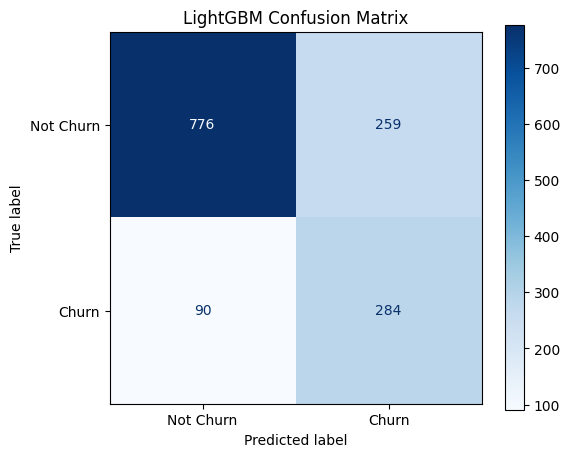

In [41]:
# Confusion Matrix
print("\nPlotting Confusion Matrix (LightGBM)...")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm, labels=lgbm_model.classes_)
disp_cm_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=['Not Churn', 'Churn'])
fig, ax = plt.subplots(figsize=(6, 5))
disp_cm_lgbm.plot(ax=ax, cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.show()

# Comparing 3 models

## Model Performance Comparison

| Model               | Recall (Churn=1) | Precision (Churn=1) | F1-Score (Churn=1) | AUC-ROC | AUC-PR (Avg Precision) |
|---------------------|------------------|---------------------|--------------------|---------|------------------------|
| Logistic Regression | *Value from Task 9* | *Value from Task 9*  | *Value from Task 9* | *Value from Task 9* | *Value from Task 9*     |
| Random Forest       | *Value from RF Eval* | *Value from RF Eval*  | *Value from RF Eval* | *Value from RF Eval* | *Value from RF Eval*     |
| LightGBM            | *Value from LGBM Eval*| *Value from LGBM Eval*| *Value from LGBM Eval* |*Value from LGBM Eval*| *Value from LGBM Eval*   |

*(Replace placeholders with actual values obtained)*

**Observations:**
* Compare the Recall for the Churn class - did the advanced models improve significantly over the baseline in catching churners?
* Compare the F1-scores for the Churn class.
* Compare AUC-ROC and especially AUC-PR scores.
* Which model seems to offer the best trade-off based on the project goals (e.g., prioritizing Recall vs. Precision)?

# Global Interpretation

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

In [45]:
# Try to get feature names from the preprocessor
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f"Successfully retrieved {len(feature_names)} feature names.")
    # Ensure it's a list
    feature_names = list(feature_names)
except Exception as e:
    print(f"Warning: Could not retrieve feature names from preprocessor: {e}")
    print("Interpretation might be difficult without feature names.")
    feature_names = None # Set to None if failed

Successfully retrieved 55 feature names.



--- Random Forest Built-in Feature Importances ---
Top 15 Features based on RF Importance:


,Feature,Importance
2,num__TotalCharges,0.120541
0,num__tenure,0.111318
1,num__MonthlyCharges,0.109803
38,cat__Contract_Month-to-month,0.063317
20,cat__OnlineSecurity_No,0.038548
29,cat__TechSupport_No,0.029998
40,cat__Contract_Two year,0.029293
45,cat__PaymentMethod_Electronic check,0.029027
18,cat__InternetService_Fiber optic,0.027317
3,num__NumOptionalServices,0.025435


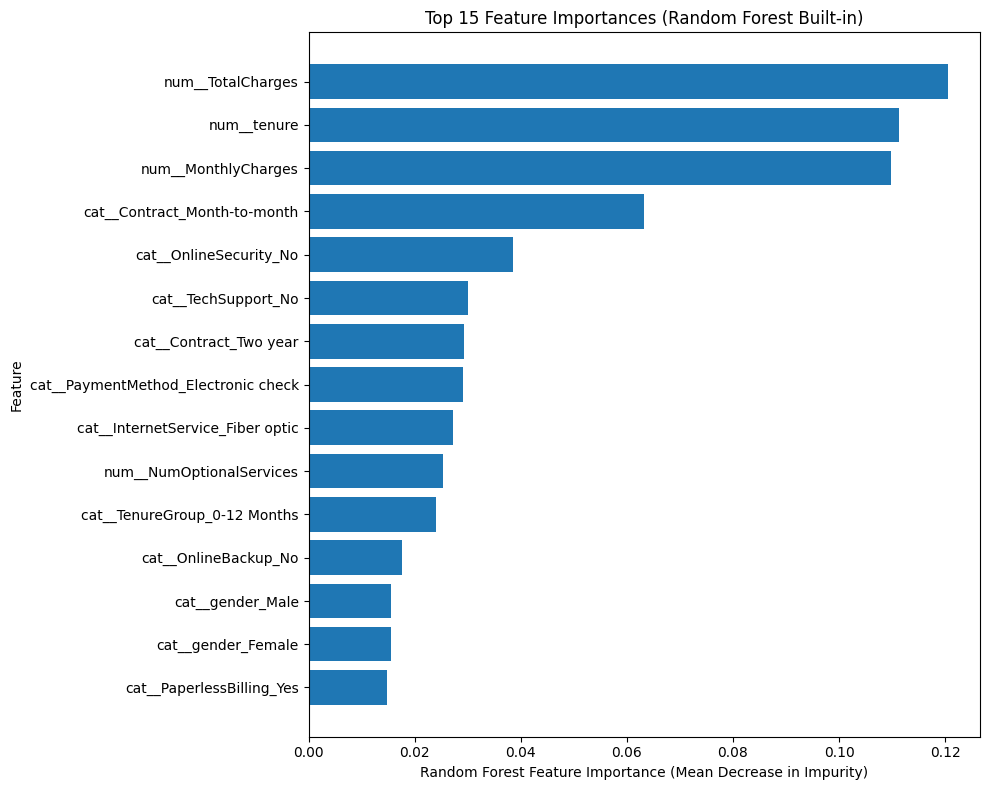

In [47]:
# 1.Built-in feature Importances
print("\n--- Random Forest Built-in Feature Importances ---")
importances = rf_model.feature_importances_

if feature_names:
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("Top 15 Features based on RF Importance:")
    display(importance_df.head(15))

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
    plt.xlabel("Random Forest Feature Importance (Mean Decrease in Impurity)")
    plt.ylabel("Feature")
    plt.title("Top 15 Feature Importances (Random Forest Built-in)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Cannot display built-in importances with names.")

In [49]:
#2: Permutation Importance ---
print("\n--- Calculating Permutation Importance (may take a moment) ---")

# Using average_precision (AUC-PR) as scoring, suitable for imbalanced data
# n_repeats=5 gives more stable results but takes longer
perm_importance_result = permutation_importance(
    rf_model,
    X_test_processed,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='average_precision', # Or 'roc_auc', 'f1', etc.
    n_jobs=-1
)



--- Calculating Permutation Importance (may take a moment) ---



Top 15 Features based on Permutation Importance (Mean Drop in AUC-PR):


,Feature,ImportanceMean,ImportanceStd
0,num__tenure,0.034697,0.007196
38,cat__Contract_Month-to-month,0.019528,0.007838
2,num__TotalCharges,0.016703,0.009557
47,cat__TenureGroup_0-12 Months,0.007579,0.004694
40,cat__Contract_Two year,0.006598,0.003938
29,cat__TechSupport_No,0.004507,0.005140
18,cat__InternetService_Fiber optic,0.003580,0.007325
44,cat__PaymentMethod_Credit card (automatic),0.003138,0.003525
20,cat__OnlineSecurity_No,0.002448,0.005822
13,cat__PhoneService_Yes,0.001795,0.000379


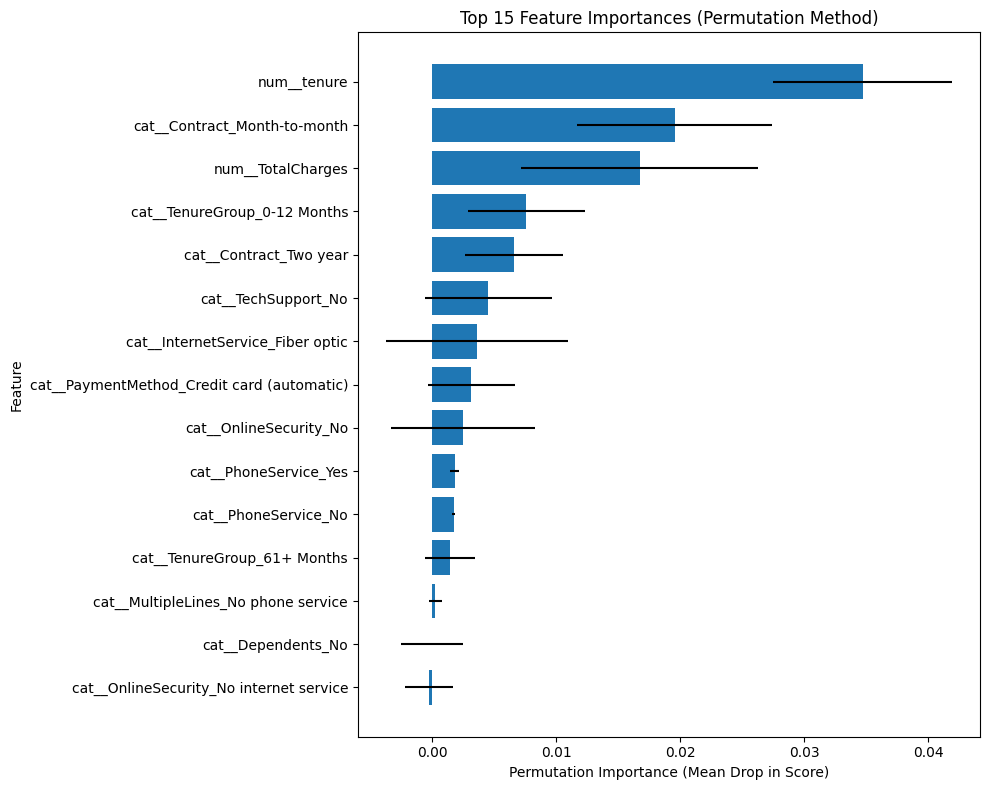

In [50]:
# Store results in a DataFrame
if feature_names:
    perm_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'ImportanceMean': perm_importance_result.importances_mean,
        'ImportanceStd': perm_importance_result.importances_std
    })
    perm_importance_df = perm_importance_df.sort_values(by='ImportanceMean', ascending=False)

    print("\nTop 15 Features based on Permutation Importance (Mean Drop in AUC-PR):")
    display(perm_importance_df.head(15))

    # Plotting permutation importance
    plt.figure(figsize=(10, 8))
    plt.barh(perm_importance_df['Feature'][:15], perm_importance_df['ImportanceMean'][:15],
             xerr=perm_importance_df['ImportanceStd'][:15]) # Add error bars
    plt.xlabel("Permutation Importance (Mean Drop in Score)")
    plt.ylabel("Feature")
    plt.title("Top 15 Feature Importances (Permutation Method)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Cannot display permutation importances with names.")